In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
####### Grid world class that includes all the necessary methods for building thee grid as well as algorithms for DP, MC and SARSA #######
class GridWorld(object):
    def __init__(self):
        
        ### Attributes defining the Gridworld #######
        
        # probability that desired action occurs
        p = 0.7
        
        # Shape of the gridworld
        self.shape = (6,6)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,1),(2,3),(2,5),(3,1),(4,1),(4,2),(4,4)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(1,0),(4,3)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10, -100] #corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        
        # Action names
        self.action_names = ['N','E','S','W']
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.action_randomizing_array = [p, (1-p)/3, (1-p)/3 , (1-p)/3]
        
        ############################################
    
    
    
        #### Internal State  ####
        
    
        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 27 of them)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T
        
        # Reward function (3D tensor)
        self.R = R
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states
        self.locs = locs
        
        # Starting location
        self.starting_loc = self.get_starting_loc()
        
        #indizes of absorbing states
        self.absorbing_indizes = [self.loc_to_state(state_id,self.locs) for state_id in self.absorbing_locs]
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)))
        self.initial[0,self.starting_state] = 1
        
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=-20
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()
        ################################
    
     
    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    #get random starting location with probability of 1/27
    def get_starting_loc(self):  
        possible_starts = [state for state in self.locs if state not in self.absorbing_locs]
        index = np.random.choice(range(len(possible_starts)))
        return possible_starts[index]
    
    ########################
    
    
    ########### Internal Helper Functions #####################
    def paint_maps(self):
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders)
        plt.show()
        
    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        for action in range(4):
            for effect in range(4):
                
                # Randomize the outcome of taking an action
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1
    
                # Fill the transition matrix
                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                    
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T,R,absorbing,locations
    
    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 

 
    
    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
###########################################         
    
    
    ####### Methods for Dynammic Programming #########
    
    def policy_evaluation(self, policy, threshold, discount, V = 0):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        if V == 0:
            V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        # While the Value has not yet converged do:
        while delta>threshold:
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):    
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V
    
    
    ### policy iteration algorithm that computes our optimal policy as well as optimal value function using dynamic programming
    def policy_iteration_algorithm(self,policy, threshold, discount):
        #get current optimal value function for initial policy
        V = self.policy_evaluation(policy, threshold, discount)
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        policy_stable = False

        while not policy_stable:
            
            #make deep copy of policy for later comparison
            b = np.copy(policy)
            for state_idx in range(policy.shape[0]):
                
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                #set Q(s,a) for s with index state_idx
                values_per_action = np.zeros(self.action_size)
                for action_idx in range(self.action_size):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(self.state_size):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    #fill Q(s,a) for s with index state_idx
                    values_per_action[action_idx] = tmpQ
                #update greedy policy
                policy[state_idx] = np.zeros(self.action_size)
                policy[state_idx][np.argmax(values_per_action)] = 1

            #if policy does no longer change after iterations leave while loop
            if (b == policy).all():
                policy_stable = True
            #get optimal value function for optimal policy found before
            V = self.policy_evaluation(policy, threshold, discount)
        
        return policy,V
                
    
    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers)
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]):
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[action]
            location = self.locs[state]
            plt.text(location[1], location[0], action_arrow, ha='center', va='center')
        
        plt.savefig('arrows_policy.png')
        plt.show()
        
    def draw_values(self, V):
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers)
        #plt.hold('on')
        for state, value in enumerate(V):
            if(self.absorbing[0,state]):
                continue
            location = self.locs[state]
            plt.text(location[1], location[0], np.round_(value, 1), ha='center', va='center')
        
        plt.savefig('values.png')
        plt.show()
    ##########################
    
     
    ########## Helper methods for MC and SARSA####################
    
    def rmse(self, actual, predicted):
        return np.sqrt(np.mean((predicted-actual)**2))
    
    def generate_episode(self, policy, starting_state = None):
        #get random starting location and index of this location in our locs list or always start from same starting_point (possible because of epsilon greedy policy)
        if not starting_state:
            state = self.get_starting_loc()
        else:
            state = starting_state
        state_idx = self.loc_to_state(state,self.locs)
        
        #declare empty episode
        episode = np.empty((0,5))
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        i = 0
        #loop forever until we hit a terminal state s_1 or s_11
        while state not in self.absorbing_locs:
            #choose action in currwent state randomly according to policy
            action_idx = np.random.choice([0,1,2,3], 1, p = policy[state_idx])
            
            #find out at which state you end up according to transition matrix (walls etc. already included)
            next_state_idx = np.random.choice(range(len(self.locs)), 1, p = np.concatenate(T[:,state_idx,action_idx], axis=0))[0]    
            next_state_array = np.array([[i, state_idx, action_idx[0], R[next_state_idx,state_idx,action_idx][0], next_state_idx]])

            #append to episode the init state, action, reward collected and next state  
            episode = np.append(episode,next_state_array, axis=0)

            #update new state
            state = self.locs[int(next_state_idx)]
            state_idx = self.loc_to_state(state,self.locs)
            i+=1
        
        return episode
    
    
    ########## MC algorithm ####################
    
    def monte_carlo_iterative_optimisation(self, iterations, alpha, epsilon, discount = 1, optimal_value = None, starting_state = None, const_epsilon=False, epsilon_steps = False):
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        #set initial policy to uniform, which is an epsilon greedy policy in the first iteration
        policy= np.zeros((grid.state_size, grid.action_size))
        policy.fill(0.25)
        
        #set total returns array to later evaluate the learning progress of agent
        total_returns = np.zeros(iterations)
        
        #check if we want to compute rmse
        if optimal_value:
            optimal_values = self.policy_iteration_algorithm(policy, discount)[1]
            rmse = np.zeros(iterations)
        else:
            rmse = 0
        
        #set initial Q to 0
        Q = np.zeros([policy.shape[0], self.action_size])
        
        
        for i in range(iterations):
            
            #generate episode with random starting state if starting_state = None
            episode = self.generate_episode(policy, starting_state)
            
            #get the total return for an episode discounted, flip because of backward discounted
            discounted_total_returns = np.zeros(episode.shape[0])
            for index,reward in enumerate(np.flip(episode[:,3])):
                discounted_total_returns[index] = reward*discount**index
            total_returns[i] = np.sum(discounted_total_returns)
            
            
            for state_idx in range(policy.shape[0]):
                #find starting index where state occurs for the first time and calculate the sum of returns from the found index onwards
                if state_idx in episode[:,1]:
                    
                    for action_idx in range(self.action_size):
                        #create mask
                        mask = ((episode[:,1]==state_idx) & (episode[:,2]==action_idx))
                        #check whether mask exists
                        if mask.any():
                            starting_index = int(episode[mask][0][0])
                            
                            #discount returns of each state action pair
                            discounted_returns = np.zeros(episode[starting_index:].shape[0])
                            for idx,r in enumerate(episode[starting_index:,3]):
                                discounted_returns[idx] = r*discount**idx

                            #sum up over the successor returns
                            individual_return = np.sum(discounted_returns)
                            
                            #update q iteratively
                            Q[state_idx][action_idx] += alpha*(individual_return-Q[state_idx][action_idx])
           
            #set up new epsilon greedy policy according to epsilon**i or epsilon or epsilon/(i+1)       
            for policy_state in range(self.state_size):
                epsilon_decay = epsilon**i
                if const_epsilon:
                    epsilon_decay = epsilon
                if epsilon_steps:
                    epsilon_decay = epsilon/(i+1)
                policy[policy_state] = epsilon_decay/(self.action_size)
                policy[policy_state][np.argmax(Q[policy_state])] = 1-epsilon_decay + epsilon_decay/(self.action_size)
    
            
            # if optimal value True then calculate rmses
            if optimal_value:
                temp_V = np.array([np.dot(policy[state],Q[state]) for state in range(self.state_size)])
                rmse[i] = self.rmse(optimal_values, temp_V)

        #return values and not state action values
        V = np.array([np.dot(policy[state],Q[state]) for state in range(policy.shape[0])])
        return policy, V, total_returns, rmse, Q
    
    
    ### MC algorithm with decaying alpha, only for trying out ##########
    
    #def mc_iterative_optimisation_decaying_alpha(self, iterations, alpha, epsilon, discount = 1, optimal_value = None, starting_state = None):
    #    
    #    #Get the reward and transition matrices
    #    R = self.get_reward_matrix()
    #    T = self.get_transition_matrix()
    #    
    #    #set initial policy to uniform, which is an epsilon greedy policy in the first iteration
    #    policy= np.zeros((grid.state_size, grid.action_size))
    #    policy.fill(0.25)
    #    
    #    #set returns array to keep count and the total return(return of entire episode)
    #    returns = np.zeros([policy.shape[0],4])
    #    total_returns = np.zeros(iterations)
    #    
    #    #check if we want to compute rmse
    #    if optimal_value:
    #        optimal_values = self.policy_iteration_algorithm(policy, discount)[1]
    #        rmse = np.zeros(iterations)
    #    else:
    #        rmse = 0
    #    
    #    #set initial Q to 0
    #    Q = np.zeros([policy.shape[0], self.action_size])
    #    
    #    for i in range(iterations):
    #        episode = self.generate_episode(policy)
    #        #get the total return for an episode discounted
    #        discounted_total_returns = np.zeros(episode.shape[0])
    #        for index,reward in enumerate(episode[:,3]):
    #            discounted_total_returns[index] = reward*discount**index
    #        total_returns[i] = np.sum(discounted_total_returns)
    #        #total_returns[i] = np.sum(episode[:,3]) 
    #        for state_idx in range(policy.shape[0]):
    #            #find starting index where state occurs for the first time and calculate the sum of returns from the found index onwards
    #            if state_idx in episode[:,1]:
    #                
    #                for action_idx in range(self.action_size):
    #                    #create mask
    #                    mask = ((episode[:,1]==state_idx) & (episode[:,2]==action_idx))
    #                    #check whether mask exists
    #                    if mask.any():
    #                        starting_index = int(episode[mask][0][0])
    #                        
    #                        #discount returns of each stae action pair
    #                        discounted_returns = np.zeros(episode[starting_index:].shape[0])
    #                        for idx,r in enumerate(episode[starting_index:,3]):
    #                            discounted_returns[idx] = r*discount**idx
    #                        
    #                        #sum up over the successor returns
    #                        individual_return = np.sum(discounted_returns) 
    #                        returns[state_idx][action_idx] += 1
    #                        
    #                        Q[state_idx][action_idx] += alpha/(returns[state_idx][action_idx])*(individual_return-Q[state_idx][action_idx])
    #                
    #                #set policy for that state to epsilon/4
    #        for policy_state in range(self.state_size):
    #            epsilon_decay = np.maximum(epsilon**i, 0.05)
    #            policy[policy_state] = epsilon_decay/(self.action_size)
    #            policy[policy_state][np.argmax(Q[policy_state])] = 1-epsilon_decay + epsilon_decay/(self.action_size)
    #                #policy[state_idx] = epsilon/(self.action_size*(i+2))
    #                #policy[state_idx][np.argmax(Q[state_idx])] = 1-epsilon/(i+2) + epsilon/(self.action_size*(i+2))
    #        
    #        # if optimal value True then calculate rmses
    #        if optimal_value:
    #            temp_V = np.array([np.dot(policy[state],Q[state]) for state in range(self.state_size)])
    #            rmse[i] = self.rmse(optimal_values, temp_V)
    #    
    #    #make policy deterministic
    #    for policy_state in range(self.state_size):
#
    #            policy[policy_state] = 0
    #            policy[policy_state][np.argmax(Q[policy_state])] = 1
    #    
    #    V = np.array([np.dot(policy[state],Q[state]) for state in range(policy.shape[0])])
    #    return policy, V, total_returns, rmse, Q
    
    
    
    ##### SARSA algorithm #################
    
    def sarsa(self, iterations, alpha, epsilon, discount = 1, optimal_value = None, const_alpha = False, const_epsilon = False):
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        #set initial policy to uniform, which is an epsilon greedy policy in the first iteration
        policy= np.zeros((grid.state_size, grid.action_size))
        policy.fill(0.25)
        
        #set total returns array for later comparison of algorithm progress over episodes trained
        total_returns = np.zeros(iterations)
        #set array which will correspond to our state_action counter N(s,a)
        state_action_counter = np.zeros([policy.shape[0],4])
        
        #check if we want to compute rmse
        if optimal_value:
            optimal_values = self.policy_iteration_algorithm(policy, discount)[1]
            rmse = np.zeros(iterations)
        else:
            rmse = 0
        
        #set initial Q to -1 since our step penalty is -1 and for terminal states set eqqual to 0
        Q = np.ones([self.state_size, self.action_size])*-1
        for terminal in self.absorbing_indizes:
            Q[terminal,:] = 0 

        
        for i in range(iterations):
            
            #get random starting state
            state = self.get_starting_loc()
            state_idx = self.loc_to_state(state,self.locs)
            
            #choose action in starting state randomly according to policy
            action_idx = np.random.choice([0,1,2,3], 1, p = policy[state_idx])
            
            #increment to take into account discount for keeping track of the total_returns array
            episode_counter = 0
            
            #initialize array which will be used to store all rewards per episode to later calculate total backwards discounted return
            disc_return_array = np.empty(0)
            
            #loop forever until we hit a terminal state s_1 or s_11
            while state_idx not in self.absorbing_indizes:
            
                #observe next R and S'
                next_state_idx = np.random.choice(range(len(self.locs)), 1, p = np.concatenate(T[:,state_idx,action_idx], axis=0))[0]    
                next_return = R[next_state_idx,state_idx,action_idx][0]
                #increment N(s,a)
                state_action_counter[state_idx][action_idx] += 1
                
                #append array with reward
                disc_return_array = np.append(disc_return_array, next_return)
                
                #choose next action
                next_action_idx = np.random.choice([0,1,2,3], 1, p = policy[state_idx])
                
                #check if next state is absorbing state and assign new Qs
                if int(self.absorbing[0,next_state_idx]) == 1:
                    Q[state_idx][action_idx] += alpha/(state_action_counter[state_idx][action_idx])*(next_return-Q[state_idx][action_idx])
                else:
                    Q[state_idx][action_idx] += alpha/(state_action_counter[state_idx][action_idx])*(next_return+discount*Q[next_state_idx][next_action_idx]-Q[state_idx][action_idx])
                
                #if alpha given is constant then do this
                if const_alpha == True:
                    if int(self.absorbing[0,next_state_idx]) == 1:
                        Q[state_idx][action_idx] += alpha*(next_return-Q[state_idx][action_idx])
                    else:
                        Q[state_idx][action_idx] += alpha*(next_return+discount*Q[next_state_idx][next_action_idx]-Q[state_idx][action_idx])
                
                #update policy according to decaying epsilon equal to epsilon/(i+1)
                policy[state_idx] = epsilon/(self.action_size*(i+1))
                policy[state_idx][np.argmax(Q[state_idx])] = 1-epsilon/(i+1) + epsilon/(self.action_size*(i+1))
                
                #if constant epsilon given, update policy accordingly
                if const_epsilon == True:
                    policy[state_idx] = epsilon/(self.action_size)
                    policy[state_idx][np.argmax(Q[state_idx])] = 1-epsilon + epsilon/(self.action_size)
                
                #iterate
                state_idx = next_state_idx
                action_idx = next_action_idx
                episode_counter += 1
                
                #backwards discounting and save in total_returns array
                if state_idx in self.absorbing_indizes:
                    for j,return_value in enumerate(np.flip(disc_return_array)):
                        total_returns[i] += return_value * discount ** j
            
            # if optimal value True then calculate rmses
            if optimal_value:
                temp_V = np.array([np.dot(policy[state],Q[state]) for state in range(self.state_size)])
                rmse[i] = self.rmse(optimal_values, temp_V)
        
        #make policy deterministic
        for policy_state in range(self.state_size):

                policy[policy_state] = 0
                policy[policy_state][np.argmax(Q[policy_state])] = 1
        
        #calculate V from our almost deterministic policy and Q
        V = np.array([np.dot(policy[state],Q[state]) for state in range(self.state_size)])
        return policy, V, total_returns, rmse, Q
    
    
    ####### means over sufficient number of algorithm runs - relevant for plotting learning curves #########
    
    def mc_mean_total_return(self,iterations, sufficient_number,alpha,epsilon, discount = 1, optimal_value = None, starting_state = None, const_epsilon=False, epsilon_steps = False):
        total_returns = np.zeros([iterations,sufficient_number])
        total_rmse = np.zeros([iterations,sufficient_number])
        
        for i in range(sufficient_number):
            total_returns[:,i], total_rmse[:,i] = self.monte_carlo_iterative_optimisation(iterations, alpha, epsilon, discount, optimal_value, starting_state, const_epsilon, epsilon_steps)[2:4]
            
        return np.mean(total_returns, axis = 1), np.std(total_returns, axis = 1), np.mean(total_rmse, axis = 1)
    
    
    def sarsa_mean_total_return(self,iterations, sufficient_number,alpha,epsilon, discount = 1, optimal_value = None, const_alpha= False, const_epsilon=False):
        total_returns = np.zeros([iterations,sufficient_number])
        total_rmse = np.zeros([iterations,sufficient_number])

        for i in range(sufficient_number):
            total_returns[:,i], total_rmse[:,i]  = self.sarsa(iterations, alpha, epsilon, discount,optimal_value, const_alpha, const_epsilon)[2:4]
                 
        return np.mean(total_returns, axis = 1), np.std(total_returns, axis = 1), np.mean(total_rmse, axis = 1)
    
    #def mc_mean_total_return_decaying_alpha(self,iterations, sufficient_number,alpha,epsilon, discount = 1, optimal_value = None, starting_state = None):
    #    total_returns = np.zeros([iterations,sufficient_number])
    #    for i in range(sufficient_number):
    #        total_returns[:,i] = self.mc_iterative_optimisation_decaying_alpha(iterations, alpha, epsilon, discount, optimal_value, starting_state)[2]
    #        
    #    return np.mean(total_returns, axis = 1), np.std(total_returns, axis = 1)
    
    
    
    
   

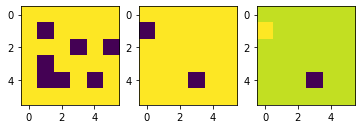

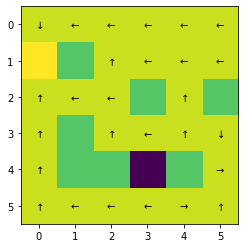

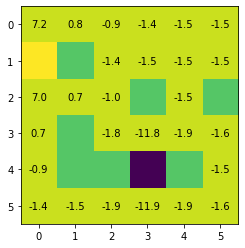

In [20]:
################ run DP and plot - Question 2a), figure 2 ################### 
discount = 0.35
threshold = 0.001
grid = GridWorld()

#build uniform policy with 0.25 for each direction
uniform_policy= np.zeros((grid.state_size, grid.action_size))
uniform_policy.fill(0.25)

optimal_policy, optimal_value_func = grid.policy_iteration_algorithm(uniform_policy, threshold, discount)

#create an array with the indeices of all the policies that are 1
optimal_arrows = np.zeros(grid.state_size).astype(int)
optimal_arrows = np.argmax(optimal_policy, axis=1)
#draw arrow grid
grid.draw_deterministic_policy(optimal_arrows)

#draw value grid
grid.draw_values(optimal_value_func)

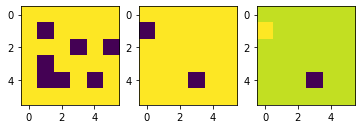

array([10., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.])

In [12]:
################ generate an episode - For testing ################### 
discount = 0.35
threshold = 0.001
grid = GridWorld()

#initiate first policy to uniform
uniform_policy= np.zeros((grid.state_size, grid.action_size))
uniform_policy.fill(0.25)


episode = grid.generate_episode(uniform_policy)
#np.flip(episode)
np.flip(episode[:,3])

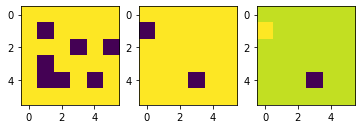

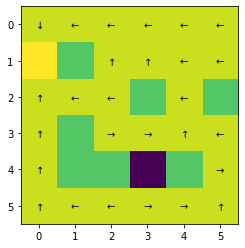

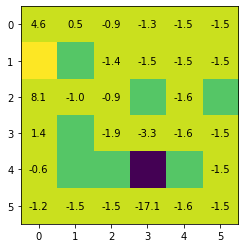

In [14]:
################ MC with constant alpha; calls monte_carlo_iterative_optimisation - Question 2c), figure 3 ################### 
discount = 0.35
iterations = 40000
alpha = 0.002
epsilon = 0.9999
grid = GridWorld()

mc_policy, mc_V, returns, rmse, Q = grid.monte_carlo_iterative_optimisation(iterations, alpha, epsilon,discount, optimal_value = None, const_epsilon = False, epsilon_steps = False)

#create an array with the indeices of all the policies that are 1
optimal_arrows = np.zeros(grid.state_size).astype(int)
optimal_arrows = np.argmax(mc_policy, axis=1)
#draw arrow grid
grid.draw_deterministic_policy(optimal_arrows)

#draw value grid
grid.draw_values(mc_V)


################ MC with constant alpha; calls monte_carlo_iterative_optimisation - Question 2c), figure 3 ################### 
discount = 0.35
iterations = 600
alpha = 0.025
epsilon = 0.994
grid = GridWorld()

mc_policy, mc_V, returns, rmse, Q = grid.monte_carlo_iterative_optimisation(iterations, alpha, epsilon,discount, optimal_value = None, const_epsilon = False, epsilon_steps = False)

#create an array with the indeices of all the policies that are 1
optimal_arrows = np.zeros(grid.state_size).astype(int)
optimal_arrows = np.argmax(mc_policy, axis=1)
#draw arrow grid
grid.draw_deterministic_policy(optimal_arrows)

#draw value grid
grid.draw_values(mc_V)

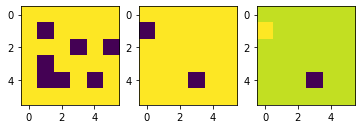

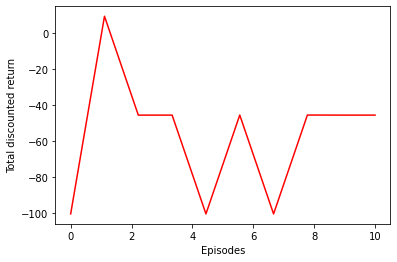

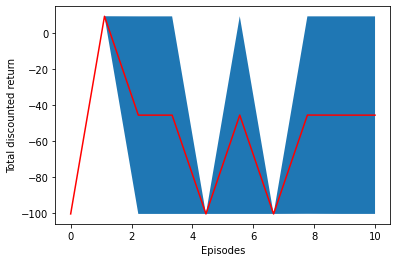

In [21]:
################ plot learning curve over sufficient number of times - Question 2c), figure 4 b) and c) - for a) just use sufficient_number = 1 ################### 
discount = 0.35
iterations =600 
sufficient_number = 250 
alpha = 0.025
epsilon = 0.994
grid = GridWorld()


returns, std, _ = grid.mc_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount)


plt.figure()
plt.plot(np.linspace(0,iterations,iterations), returns, color='r')
#plt.fill_between(np.linspace(0,iterations,iterations), returns - std, returns + std) 
plt.xlabel('Episodes')
plt.ylabel('Total discounted return')
plt.savefig('returns_mc_once.png')
plt.show()


plt.figure()
plt.plot(np.linspace(0,iterations,iterations), returns, color='r')
plt.fill_between(np.linspace(0,iterations,iterations), returns - std, returns + std)
plt.xlabel('Episodes')
plt.ylabel('Total discounted return')
plt.savefig('std.png')
plt.show()

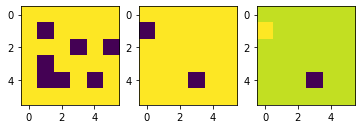

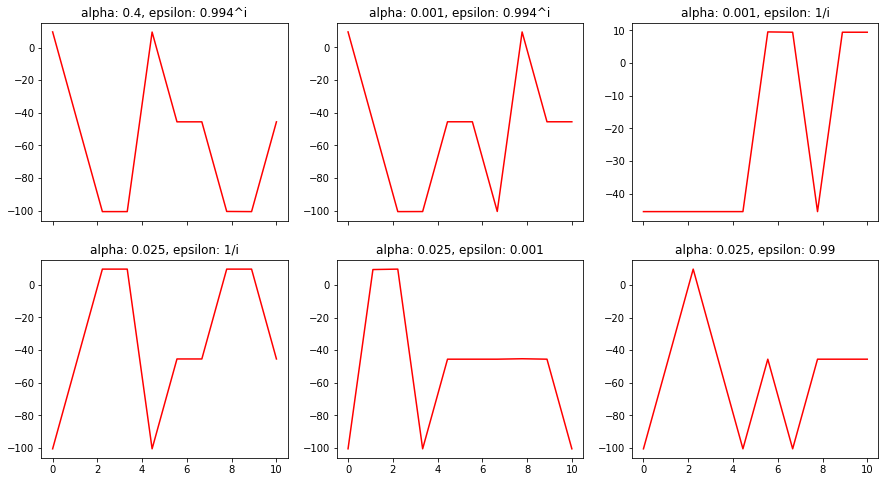

In [23]:
######## draw mc alpha epsilon comparison  - Question 2c), figure 5
def draw_varying_alpha_epsilon_mc(iterations, sufficient_number, discount):

    fig, ax = plt.subplots(2, 3, sharex='col')
                      
    alpha = 0.4
    epsilon = 0.994
    returns, _, _ = grid.mc_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount)
    ax[0,0].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[0,0].set_title('alpha: {}, epsilon: {}^i'.format(alpha, epsilon))
    
    alpha = 0.001
    epsilon = 0.994
    returns, _, _ = grid.mc_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount)
    ax[0,1].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[0,1].set_title('alpha: {}, epsilon: {}^i'.format(alpha, epsilon))
                      
    
    alpha = 0.001
    epsilon = 1
    returns, _, _ = grid.mc_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = None, starting_state = None, const_epsilon=False, epsilon_steps=True)
    ax[0,2].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[0,2].set_title('alpha: {}, epsilon: {}/i'.format(alpha, epsilon))
    
    alpha = 0.025
    epsilon = 1
    returns, _, _ = grid.mc_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = None, starting_state = None, const_epsilon=False, epsilon_steps=True)
    ax[1,0].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[1,0].set_title('alpha: {}, epsilon: {}/i'.format(alpha, epsilon))
                      
    alpha = 0.025
    epsilon = 0.001
    returns, _, _ = grid.mc_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = None, starting_state = None, const_epsilon=True)
    ax[1,1].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[1,1].set_title('alpha: {}, epsilon: {}'.format(alpha, epsilon))
    
    alpha = 0.025
    epsilon = 0.99
    returns, _, _ = grid.mc_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = None, starting_state = None, const_epsilon=True)
    ax[1,2].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[1,2].set_title('alpha: {}, epsilon: {}'.format(alpha, epsilon))
    
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.savefig('comparison.png')
    plt.show()
    

grid = GridWorld()
iterations = 600
sufficient_number = 250
draw_varying_alpha_epsilon_mc(iterations,sufficient_number,0.35)

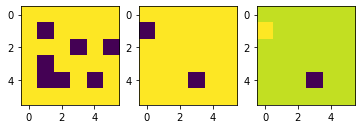

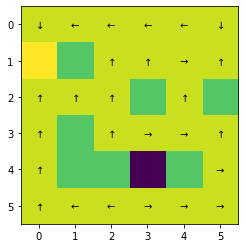

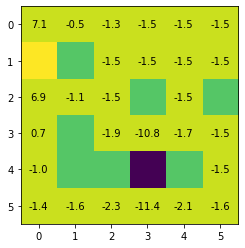

In [18]:
################ TD with decaying alpha; calls sarsa - Question 2d), figure 6 ################### 
discount = 0.35
iterations = 40000
alpha = 1 # alpha is 1/n(s,a)
epsilon = 1 #epsilon is 1/i
grid = GridWorld()

td_policy, td_V, returns, rmse, Q = grid.sarsa(iterations, alpha, epsilon, discount, optimal_value = None, const_alpha = False)

#create an array with the indeices of all the policies that are 1
optimal_arrows = np.zeros(grid.state_size).astype(int)
optimal_arrows = np.argmax(td_policy, axis=1)
#draw arrow grid
grid.draw_deterministic_policy(optimal_arrows)

#draw value grid
grid.draw_values(td_V)

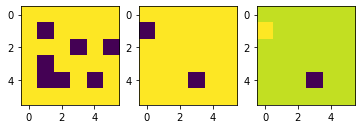

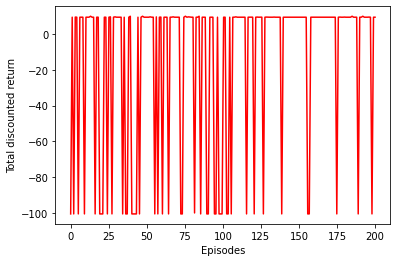

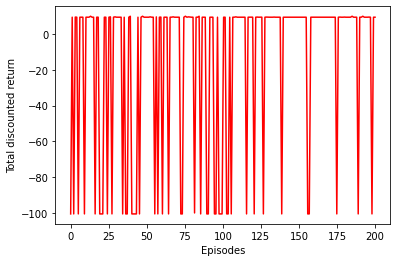

In [24]:
################ plot convergence over sufficient number of times - Question 2d), figure 7 b) and c) - for a) just use sufficient_number = 1 ################### 
discount = 0.35
iterations =200
sufficient_number = 250 
alpha = 1
epsilon = 1
grid = GridWorld()


returns, std, _ = grid.sarsa_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = None, const_alpha = False, const_epsilon = False)


plt.figure()
plt.plot(np.linspace(0,iterations,iterations), returns, color='r')
plt.xlabel('Episodes')
plt.ylabel('Total discounted return')
plt.savefig('returns_td.png')
plt.show()


plt.figure()
plt.plot(np.linspace(0,iterations,iterations), returns, color='r')
plt.fill_between(np.linspace(0,iterations,iterations), returns - std, returns + std)
plt.xlabel('Episodes')
plt.ylabel('Total discounted return')
plt.savefig('std_td.png')
plt.show()

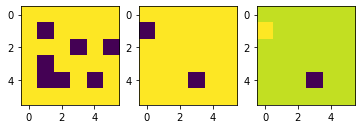

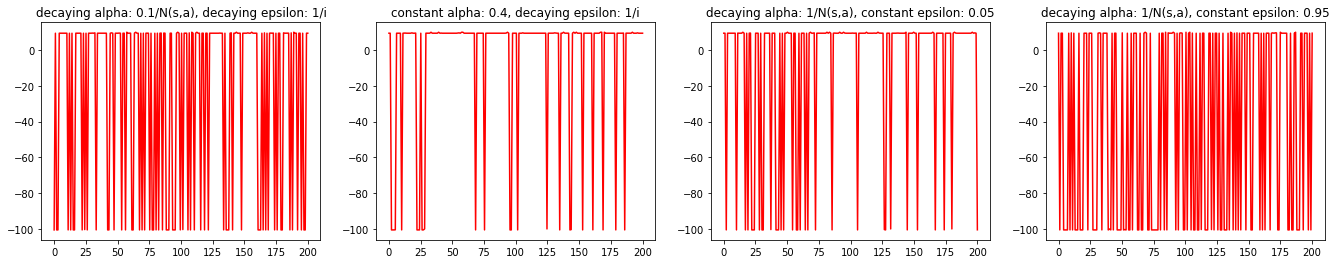

In [25]:
######## draw sarsa alpha epsilon comparison  - Question 2d), figure 8 ######
def draw_varying_alpha_epsilon_sarsa(iterations, sufficient_number, discount):

    fig, ax = plt.subplots(1, 4, sharex='col')

    alpha = 0.1
    epsilon = 1
    returns, _, _ = grid.sarsa_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount)
    ax[0].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[0].set_title('decaying alpha: {}/N(s,a), decaying epsilon: {}/i'.format(alpha, epsilon))
                      
    alpha = 0.4
    epsilon = 1
    returns, _, _ = grid.sarsa_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = None, const_alpha = True, const_epsilon = False)
    ax[1].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[1].set_title('constant alpha: {}, decaying epsilon: {}/i'.format(alpha, epsilon))
                      
    alpha = 1
    epsilon = 0.05
    returns, _, _ = grid.sarsa_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = None, const_alpha = False, const_epsilon = True)
    ax[2].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[2].set_title('decaying alpha: {}/N(s,a), constant epsilon: {}'.format(alpha, epsilon))
                      
    alpha = 1
    epsilon = 0.95
    returns, _, _ = grid.sarsa_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = None, const_alpha = False, const_epsilon = True)
    ax[3].plot(np.linspace(0,iterations,iterations), returns, color='r') 
    ax[3].set_title('decaying alpha: {}/N(s,a), constant epsilon: {}'.format(alpha, epsilon))
                      
    
    fig.set_figheight(4)
    fig.set_figwidth(23)
    plt.savefig('comparison_td.png')
    plt.show()
    
    
grid = GridWorld()
iterations = 200
sufficient_number = 250
draw_varying_alpha_epsilon_sarsa(iterations,sufficient_number,0.35)

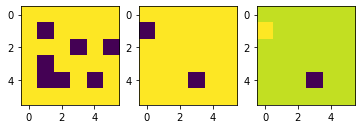

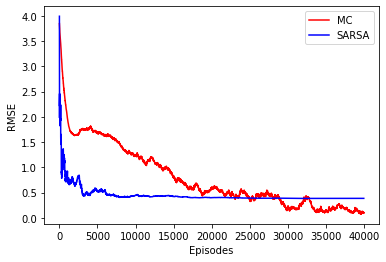

In [46]:
################ plot estimation error against episodes - Question 2e), figure 9 a) ################### 
discount = 0.35
grid = GridWorld()
iterations = 40000

#parameters for MC
epsilon = 0.9999
alpha = 0.002
rmse = grid.monte_carlo_iterative_optimisation(iterations, alpha, epsilon, discount, optimal_value = True)[3]


#parameters for SARSA
alpha = 1
epsilon = 1
rmse_sarsa = grid.sarsa(iterations, alpha, epsilon, discount, optimal_value = True)[3]

plt.figure()
plt.plot(np.linspace(0,iterations,iterations), rmse, color='r', label='MC')
plt.plot(np.linspace(0,iterations,iterations), rmse_sarsa, color='b', label='SARSA')
plt.ylabel('RMSE')
plt.xlabel('Episodes')
plt.legend()
plt.savefig('RMSE_MCandTD')
plt.show()

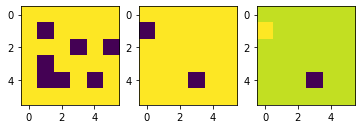

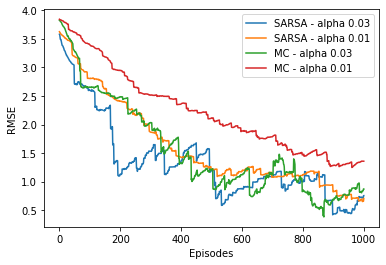

In [206]:
################ plot estimation error against episodes for multiple parameters - Question 2e), figure 9 b) ################### 
discount = 0.35
iterations = 1000
epsilon = 0.035
grid = GridWorld()
plt.figure()


alpha = 0.03
rmse = grid.sarsa(iterations, alpha, epsilon, discount, optimal_value = True, const_alpha = True, const_epsilon=True)[3]
plt.plot(np.linspace(0,iterations,iterations), rmse, label='SARSA - alpha {}'.format(alpha))

alpha = 0.01
rmse = grid.sarsa(iterations, alpha, epsilon, discount, optimal_value = True, const_alpha = True, const_epsilon=True)[3]
plt.plot(np.linspace(0,iterations,iterations), rmse, label='SARSA - alpha {}'.format(alpha))


alpha = 0.03
rmse = grid.monte_carlo_iterative_optimisation(iterations, alpha, epsilon, discount, optimal_value = True, starting_state = None, const_epsilon = True)[3]
plt.plot(np.linspace(0,iterations,iterations), rmse, label='MC - alpha {}'.format(alpha))


alpha = 0.01
rmse = grid.monte_carlo_iterative_optimisation(iterations, alpha, epsilon, discount, optimal_value = True, starting_state = None, const_epsilon = True)[3]
plt.plot(np.linspace(0,iterations,iterations), rmse, label='MC - alpha {}'.format(alpha))


plt.ylabel('RMSE')
plt.xlabel('Episodes')
plt.legend()
plt.savefig('RMSE_comparison')
plt.show()

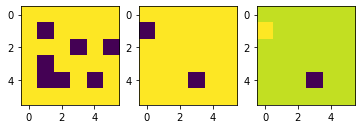

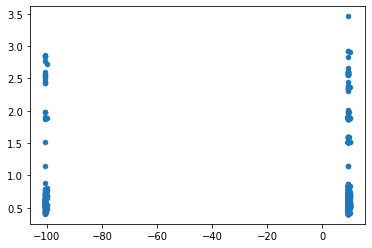

In [7]:
################ plot estimation error against rewards SARSA once- Question 2e), figure 10 a) ################### 
discount = 0.35
iterations = 600
alpha = 1
epsilon = 1
grid = GridWorld()


_, _, returns, rmse, Q = grid.sarsa(iterations, alpha, epsilon, discount, optimal_value = True)

plt.figure()
plt.scatter(returns, rmse, s = 20)
plt.show()



In [ ]:
###### plot averaged RMSE over averaged Total returns SARSA- Question 2e), figure 10 b)
discount = 0.35
iterations =600 
sufficient_number = 100 
alpha = 1
epsilon = 1
grid = GridWorld()


returns, _, rmse = grid.sarsa_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = True, const_alpha = False, const_epsilon = False)


plt.figure()
plt.scatter(returns, rmse, s=3)
#plt.fill_between(np.linspace(0,iterations,iterations), returns - std, returns + std) 
plt.xlabel('Averaged backwards discounted returns')
plt.ylabel('Averaged RMSE')
plt.savefig('what.png')
plt.show()

In [ ]:
###### plot averaged RMSE over averaged Total returns MC- Question 2e), figure 10 c)
discount = 0.35
iterations =600 #300
sufficient_number = 100 #
alpha = 0.025
epsilon = 0.994
grid = GridWorld()


returns, _, rmse = grid.mc_mean_total_return(iterations, sufficient_number,alpha,epsilon, discount, optimal_value = True)


plt.figure()
plt.scatter(returns, rmse, s=3)
#plt.fill_between(np.linspace(0,iterations,iterations), returns - std, returns + std) 
plt.xlabel('Averaged backwards discounted returns')
plt.ylabel('Averaged RMSE')
plt.savefig('what.png')
plt.show()